In [1]:
import pickle
import bs4
import gzip
import tarfile
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer, HashingVectorizer, TfidfVectorizer
from bs4 import BeautifulSoup
from tqdm import tqdm
from os import listdir
from os.path import isfile, join
from pprint import pprint

from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.decomposition import PCA, NMF, IncrementalPCA, FastICA, LatentDirichletAllocation, TruncatedSVD
from sklearn.manifold import Isomap, MDS, LocallyLinearEmbedding, TSNE

plt.style.use("ggplot")

In [2]:
#
# Removes script and html-tags - returns plain text
#
def clean_html(str):
    soup = BeautifulSoup(str,"lxml")

    # kill all script and style elements
    for script in soup(["script", "style"]):
        script.extract() # rip it out 
    
    text = soup.get_text(strip=False)
    
    text=text.replace(u'\xa0',u'')

    return text

In [3]:
#
# Get substring start index
#
def substr(str0, subs, start=0):
    for i in range(start,len(str0)+start):
        if str0[i:i+len(subs)] == subs:
            return i
    raise ValueError('No substring:',subs)
    
def rev_substr(str0, subs, start):
    for i in range(start,0,-1):
        if str0[i:i+len(subs)] == subs:
            return i
    raise ValueError('No rev substring:',subs)

def str_between(str_s, str1, str2):
    str0=str(str_s)
    start = substr(str0, str1)
    stop = substr(str0, str2, start)
    return str0[start+len(str1):stop]

def rev_str_between(str_s, str1, str2):
    str0=str(str_s)
    start = substr(str0, str1)
    stop = rev_substr(str0, str2, start)
    return str0[stop+len(str2):start]
    
# test = "<TarInfo 'alphabay/2015-04-30/search.php?s_terms=ua&pg=18' at 0x7f9dc97d2368>"
# test = "<TarInfo 'alphabay/2015-06-12/user.php?id=2680&tab=5&pg4=1' at 0x7f9dbec302a0>"
# test = " <TarInfo 'silkroad2-forums/2014-02-21/index.php?topic=11429.0' at 0x7f6098dfef20>,"
# rev_str_between(test,".php?","/")

In [4]:
#
# Read all tar-files in folder (parent)
#
def get_tars():
    parent = "/home/hades/exjobb/dumps/dnm/"
    files = [parent+f for f in listdir(parent) if isfile(join(parent, f))]
    return files

In [5]:
#
# Untar a file and return its members
# returns: tar, members
#
def open_tar(tar_fn):
    tar = tarfile.open(tar_fn, "r:xz")
    members = tar.getmembers()
    tar.close()
    return members

In [6]:
#
# read untar - using members
#
def untar1(tar_fn, mem):
    tar = tarfile.open(tar_fn, "r:xz")
    raw = []
    for m in tqdm(mem):
        fn = tar.extractfile(m)
        f = fn.read()
        f = f.decode(errors='ignore')
        raw.append(clean_html(f))
    tar.close()
    return raw

In [7]:
#
# read untar - using next
#
def untar2(tar_fn):
    tar = tarfile.open(tar_fn, "r:xz")
    raw = []
    m = tar.next()
    while m != None:
        fn = tar.extractfile(m)
        f = fn.read()
        f = f.decode(errors='ignore')
        raw.append(clean_html(f))
        m = tar.next()
    tar.close()
    return raw

In [8]:
# import shutil
# from os import walk
# from os.path import join

# #
# # Open untared member
# #
# def untar(tar, mem):
#     raw = []
#     fl = []
    
#     # extract to folder ./tmp/
#     tar.extractall(path='./tmp/',members=mem)  
    
#     # get all files
#     for path, subdirs, files in walk('./tmp/'):
#         for name in files:
#             tmp = join(path, name)
#             fl.append(tmp)
#     return fl

In [9]:
# #
# # Get content from all files
# #
# def get_content(fn_list):
#     cont = []
#     for fn in tqdm(fn_list):
#         with open(fn,"rb") as f:
#             tmp = f.read()
#             cont.append(clean_html(tmp))
#     shutil.rmtree('./tmp')
#     return(cont)

In [10]:
#
# Look for a substr in tars
#
for i,x in enumerate(get_tars()):
    if "alpha" in x:
        print(i,x)

35 /home/hades/exjobb/dumps/dnm/alphabay.tar.xz


In [16]:
#
# 1 - Get a list of tar-files (ret: tars)
# 2 - Get members from arg
# 3 - Get cleaned html-text from arg
#
tars = get_tars()
tar_fn = tars[35]  #tars[35] = alphabay
print(tar_fn)
print("Tar-files:",len(tars))

members = open_tar(tar_fn)
print("Tar-file members:",len(members))

/home/hades/exjobb/dumps/dnm/alphabay.tar.xz
Tar-files: 164


In [14]:
#
# load pickle data
#
names, content = pickle.load(open("ab.p","rb"))

In [ ]:
#
# Store content from tar in list
# pad: jump arg each iteration 
#
pad = 1

names = members[::pad]
content = untar1(tar_fn, names)

In [71]:
#
# Retireve Alphabay listing category. 
# title string
#
def get_category(str):
    ind_start = substr(str, "Home /")+6
    mid_stop = substr(str, "Listing Options", ind_start)
    ind_stop = rev_substr(str, "\n", mid_stop)
    cate = str[ind_start:ind_stop]
    cate = cate.replace("\n", "")
    cate = cate.replace(" ", "")
    return cate 

In [15]:
#
# Topic extraction using the url-name (silkroad-specific)
#

problem = []

for x in tqdm(names):
    try:
        problem.append(str_between(x,".php?","="))
#         problem.append(str_between(x,"php?","="))
    except:
        problem.append("other")

pprint(set(problem))

100%|██████████| 192670/192670 [00:02<00:00, 85797.11it/s]

{'PHPSESSID', 'other', 'action', 'topic', 'board'}


In [16]:
#
# Make the target labels numeric
#

kategorier = list(set(problem))

dc={}
i=0
for x in kategorier:
    dc[x] = i
    i+=1
    
y = ([dc.get(x) for x in tqdm(problem)])

100%|██████████| 192670/192670 [00:00<00:00, 2017698.64it/s]


In [17]:
#
# Print the distribution between the categories
#

print(len(problem))
for x in set(problem):
    print(x[:4], problem.count(x))

192670
PHPS 53
othe 135
acti 138239
topi 50729
boar 3514


In [18]:
names_str = [str(x) for x in names] 

In [206]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [ ]:
# #
# # word counter
# # 

# w_counter = CountVectorizer(stop_words='english',tokenizer=LemmaTokenizer())
# wor = w_counter.fit_transform(content)
# print(wor.shape)

In [ ]:
# from operator import itemgetter

# # a = wor.sum(axis=0)
# # print(a)
# # print(a.argmax())
# # print(w_counter.get_feature_names()[a.argmax()])
# # print(a.max())

# tmp = []
# for i in tqdm(range(a.shape[1])):
#     tmp.append(w_counter.get_feature_names()[i])

# res = list(zip(tmp, a.tolist()[0]))
# res_sort = sorted(res, key=itemgetter(1), reverse=1)
# d_key = [x for x,y in res_sort]
# d_val = [y for x,y in res_sort]

# fig = plt.gcf()
# fig.set_size_inches(18.5, 10.5)
# plt.bar(range(50), d_val[:50], align='center')
# plt.xticks(range(50), d_key[:50])
# fig.autofmt_xdate()
# plt.show()

In [22]:
#
# Featureextraction: BOW & Tf-Idf
#
tfidf_vect = TfidfVectorizer(use_idf=True)# stop_words='english',tokenizer=LemmaTokenizer()

input_data_tf = tfidf_vect.fit_transform(content)#names_str
print(input_data.shape)

(192670, 1048576)


In [52]:
#
# Featureextraction: BOW & Tf-Idf
#
hash_vect = HashingVectorizer(non_negative=1)
input_data = hash_vect.fit_transform(content)
print(input_data.shape)

(192670, 1048576)


In [59]:
# t1 = "Juri Escobar, 32, var bara tolv år när han började ta droger och begå våldsbrott. var var var"
# t2 = "I dag hjälper han andra att var hoppa av från kriminella gäng."

# hash_vect = HashingVectorizer(non_negative=1)
# tmp1 = hash_vect.fit_transform([t1])
# tmp2 = hash_vect.fit_transform([t2])
# tmp3 = hash_vect.fit_transform([t1,t2])
# print(type(tmp1))

# tmp4 = tmp1
# print(tmp3)
# tmp4 = np.vstack([tmp4, hash_vect.fit_transform([t1]).getrow(0)])
# print(tmp4)
# print(":::::")
# tmp4 = np.vstack([tmp4, hash_vect.fit_transform([t2]).getrow(0)])
# print(tmp4)

# print(tmp1.sum())
# print(tmp2.sum())
# print(tmp3.sum())
# print(tmp1.sum()+tmp2.sum())
# print((tmp1+tmp2).sum())
# print(tmp4.sum())

In [56]:
#
# reduce dimension
# Input: out dimension size - eg. 3
# Out:   X
#

def red_dimen(to):
    pca = TruncatedSVD(n_components=25)
    pca.fit(input_data)
    X = pca.transform(input_data)

#     pca = Isomap(n_components=to)
    pca = PCA(n_components=to)
    pca.fit(X)
    X = pca.transform(X)
    return X

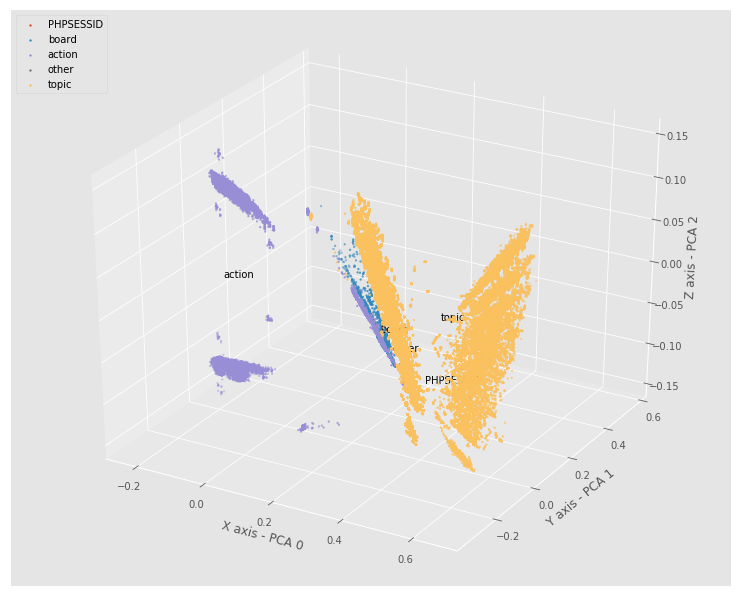

In [26]:
#
# Plot X (3D)  
# Input: X (global)
#

X = red_dimen(3)

def plot_data():
    %matplotlib inline

    fig = plt.figure(1)
    fig.set_size_inches(10,8)
    ax = Axes3D(fig)
    y = problem
    
    for name in list(set(problem)):
        ax.scatter(X[[name==t for t in y], 0], 
                  X[[name==t for t in y], 1],
                  X[[name==t for t in y], 2], label=name, s=3)
        
        ax.text3D(X[[name==t for t in y], 0].mean(),
                  X[[name==t for t in y], 1].mean(),
                  X[[name==t for t in y], 2].mean(), name)

    plt.legend(loc='upper left')
#     y = np.choose(problem, [0, 1, 2]).astype(np.float)
#     ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, s=2, cmap=plt.cm.spectra
    ax.set_xlabel('X axis - PCA 0')
    ax.set_ylabel('Y axis - PCA 1')
    ax.set_zlabel('Z axis - PCA 2')
#     ax.set_xlim3d(-0.5, 0.5)
    plt.show()
    
plot_data()

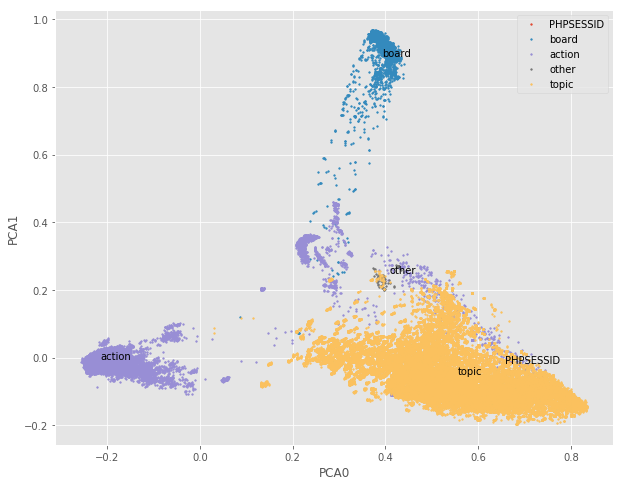

In [53]:
#
# Plot X (2D)  
# Input: X2d (global)
#

X2d = red_dimen(2)
    
def plot_data():
    %matplotlib inline
    fig = plt.figure(figsize=(10,8))
    y = problem
    
    for name in list(set(y)):
        plt.scatter(X2d[[name==t for t in y], 0],
                    X2d[[name==t for t in y], 1],
                    label=name, s=3)
        
        plt.text(X2d[[name==t for t in y], 0].mean(),
                 X2d[[name==t for t in y], 1].mean(),
                 name)
        
    plt.xlabel("PCA0")
    plt.ylabel("PCA1")
    plt.legend(loc='upper right')
    plt.show()
    
plot_data()

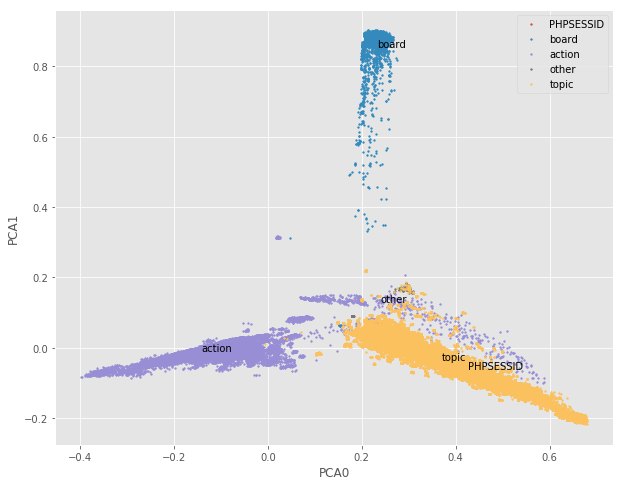

In [57]:
X2d = red_dimen(2)
    
def plot_data():
    %matplotlib inline
    fig = plt.figure(figsize=(10,8))
    y = problem
    
    for name in list(set(y)):
        plt.scatter(X2d[[name==t for t in y], 0],
                    X2d[[name==t for t in y], 1],
                    label=name, s=3)
        
        plt.text(X2d[[name==t for t in y], 0].mean(),
                 X2d[[name==t for t in y], 1].mean(),
                 name)
        
    plt.xlabel("PCA0")
    plt.ylabel("PCA1")
    plt.legend(loc='upper right')
    plt.show()    
plot_data()

In [76]:
pickle.dump((names, content), open("ab.p", "wb"), protocol=2)